In [1]:
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
import numpy as np
import os
import re
import fnmatch
import time
import split_extract
import warnings
import pandas as pd
from multiprocessing import Pool
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from params import dresden_images_root, images_db_path, patch_span, \
        patch_num, unseen_root

In [4]:
warnings.filterwarnings("ignore")

if not os.path.exists(unseen_root):
    os.makedirs(unseen_root)

In [5]:
images_db = np.load(images_db_path, allow_pickle=True).item()
# read all the trained model images and unseen model images
real_model_list = list(filter(lambda model: re.search(r'Canon*', model), images_db['brand_model']))
test_model_list = list(filter(lambda model: re.search(r'^((?!Canon).)*$', model), images_db['brand_model']))
test_img_list = list(filter(lambda img: re.search(r'^((?!Canon).)*$', img), images_db['path']))

# How many model in my dataset, real are trained models, test are unseen models
real_model = np.unique(real_model_list) 
test_model = np.unique(test_model_list) 
print("real models: {}".format(', '.join(real_model)))
print("test models: {}".format(', '.join(test_model)))

for model in test_model:
    tmp_list = fnmatch.filter(test_model_list, model + '*')
    print("{} in test set: {}.".format(model, len(tmp_list)))

real models: Canon_Ixus55, Canon_Ixus70, Canon_PowerShotA640
test models: Nikon_CoolPixS710, Nikon_D200, Nikon_D70, Nikon_D70s, Sony_DSC-H50, Sony_DSC-T77, Sony_DSC-W170
Nikon_CoolPixS710 in test set: 925.
Nikon_D200 in test set: 752.
Nikon_D70 in test set: 736.
Nikon_D70s in test set: 367.
Sony_DSC-H50 in test set: 541.
Sony_DSC-T77 in test set: 725.
Sony_DSC-W170 in test set: 405.


In [6]:
test_list = []
for img_brand_model, img_path in zip(test_model_list, test_img_list):
        test_list += [{'data_set':'test',
                       'img_path':img_path,
                       'img_brand_model':img_brand_model,
                       'patch_span':patch_span,
                       'patch_num':patch_num,
                       'patch_root': unseen_root,
                       'img_root': dresden_images_root
                       }]

num_processes = 12
pool = Pool(processes=num_processes)

In [7]:
test_paths = pool.map(split_extract.extract, test_list)
print('Completed.')

Completed.


In [8]:
# Define image and batch size
img_height = 256
img_width = 256
batch_size = 64

# Load and Compile the model
model = tf.keras.models.load_model('model.h5')
test_data_gen = ImageDataGenerator(preprocessing_function=None,
    rescale=1./255)
# Read the positive test samples.
test_generator = test_data_gen.flow_from_directory(
                  directory = r"./unseen/test/",
                  target_size=(img_width, img_height), color_mode='grayscale', shuffle=True,
                  batch_size=batch_size, class_mode="categorical")

Found 102100 images belonging to 7 classes.


In [9]:
# generate a histogram, which for every unseen models, how many imgs are classified.
t0 = time.time()
hist = [[0, 0, 0] for i in range(len(test_model))]

for i in range(200):
    gen = next(test_generator)
    pred = model.predict(gen[0])
    pred_labels = np.argmax(pred, axis=1)
    real_labels = np.argmax(gen[1], axis=1)
    for j in range(len(pred_labels)):
        hist[real_labels[j]][pred_labels[j]] += 1
t1 = time.time()
print('It tooks {:d} seconds'.format(int(t1-t0)))

It tooks 335 seconds


                   Canon_Ixus55  Canon_Ixus70  Canon_PowerShotA640
Nikon_CoolPixS710            86          1495                 1275
Nikon_D200                   29          1053                 1293
Nikon_D70                     0          1174                    0
Nikon_D70s                    0          1098                    2
Sony_DSC-H50                  0          1708                    0
Sony_DSC-T77                  3          2321                    0
Sony_DSC-W170                 0          1263                    0


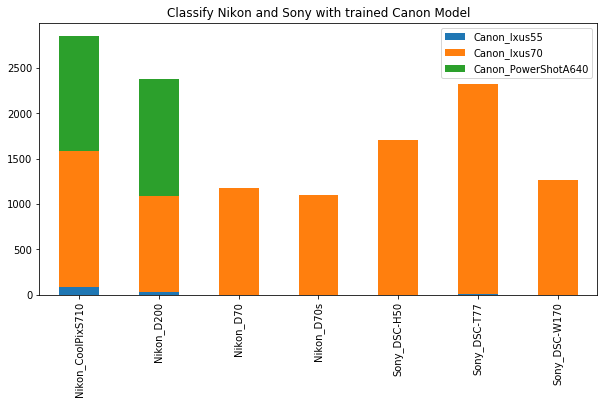

In [10]:
df = pd.DataFrame(hist, index=test_model, columns=real_model)
print(df)
df.plot.bar(stacked=True, figsize=(10, 5), title='Classify Nikon and Sony with trained Canon Model')